In [0]:
#import the necessary libraries
import fastai
from fastai import *
from fastai.text import * 
import pandas as pd
import numpy as np
from functools import partial
import io
import os

In [0]:
#define clean funtion to remove links, mentions and hashtags
def clean(strng):
  strng = re.sub('(https?:\/\/)?([\da-z\.-]+)\.([a-z\.]{2,6})([\/\w\.-]*)*\/?\S', '', strng, flags=re.MULTILINE)
  strng = re.sub(r'[A-Za-z0-9]+', '', strng, flags=re.MULTILINE)
  strng = ''.join(re.sub("(@[A-Za-z0–9]+)|(#[A-Za-z0–9]+)|([@])|([#])|([,])|([\.])|([\/])|([\\])|([\)])|([\(])|([-])|([\:])|([\?])|([_])|([!])","",strng))
  strng = ''.join(re.sub("(\')|(\")", "", strng))
  strng = strng.strip()
  return strng

#clean the data
df = pd.read_excel("data.ods", engine="odf")
for i in range(df['Text'].size):
    df['Text'][i] = clean(df['Text'][i])
df.head()

,Text,Label
0,लोग वतन तक खा जाते हैं इसका इसे यकीन नहींमान ज...,negative
1,गुमनाम है वतन पर मिटने वाले लोग आतन्कवादियों स...,negative
2,ज़ंजीर बदली जा रही थी मैं समझा था रिहाई हो गयी है,negative
3,यूपी में बड़े स्तर पर दंगे करवा सकती है बीजेपी...,negative
4,अंग्रेजी नहीं आती है इसलिए हिन्दी ट्विट ज्यादा...,negative


In [0]:
#remove the stop words
hindi_stop_words = ["अंदर","अत","अदि","अप","अपना","अपनि","अपनी","अपने","अभि","अभी","आदि","आप","इंहिं","इंहें","इंहों","इतयादि","इत्यादि","इन","इनका","इन्हीं","इन्हें","इन्हों","इस","इसका","इसकि","इसकी","इसके","इसमें","इसि","इसी","इसे","उंहिं","उंहें","उंहों","उन","उनका","उनकि","उनकी","उनके","उनको","उन्हीं","उन्हें","उन्हों","उस","उसके","उसि","उसी","उसे","एक","एवं","एस","एसे","ऐसे","ओर","और","कइ","कई","कर","करता","करते","करना","करने","करें","कहते","कहा","का","काफि","काफ़ी","कि","किंहें","किंहों","कितना","किन्हें","किन्हों","किया","किर","किस","किसि","किसी","किसे","की","कुछ","कुल","के","को","कोइ","कोई","कोन","कोनसा","कौन","कौनसा","गया","घर","जब","जहाँ","जहां","जा","जिंहें","जिंहों","जितना","जिधर","जिन","जिन्हें","जिन्हों","जिस","जिसे","जीधर","जेसा","जेसे","जैसा","जैसे","जो","तक","तब","तरह","तिंहें","तिंहों","तिन","तिन्हें","तिन्हों","तिस","तिसे","तो","था","थि","थी","थे","दबारा","दवारा","दिया","दुसरा","दुसरे","दूसरे","दो","द्वारा","न","नहिं","नहीं","ना","निचे","निहायत","नीचे","ने","पर","पहले","पुरा","पूरा","पे","फिर","बनि","बनी","बहि","बही","बहुत","बाद","बाला","बिलकुल","भि","भितर","भी","भीतर","मगर","मानो","मे","में","यदि","यह","यहाँ","यहां","यहि","यही","या","यिह","ये","रखें","रवासा","रहा","रहे","ऱ्वासा","लिए","लिये","लेकिन","व","वगेरह","वरग","वर्ग","वह","वहाँ","वहां","वहिं","वहीं","वाले","वुह","वे","वग़ैरह","संग","सकता","सकते","सबसे","सभि","सभी","साथ","साबुत","साभ","सारा","से","सो","हि","ही","हुअ","हुआ","हुइ","हुई","हुए","हे","हें","है","हैं","हो","होता","होति","होती","होते","होना","होने"]
tknzd = df['Text'].apply(lambda x: x.split())
tknzd_d = tknzd.apply(lambda x: [item for item in x if item not in hindi_stop_words])

cleaned = [] 
for i in range(len(df)): 
    t = ' '.join(tknzd_d[i]) 
    cleaned.append(t) 
df['Text'] = cleaned

In [0]:
df.head()

,Text,Label
0,लोग वतन खा जाते यकीन नहींमान जाएगा तू ले जाकर ...,negative
1,गुमनाम वतन मिटने लोग आतन्कवादियों मिलकर मशहूर गये,negative
2,ज़ंजीर बदली रही मैं समझा रिहाई गयी,negative
3,यूपी बड़े स्तर दंगे करवा सकती बीजेपी मुलायम सि...,negative
4,अंग्रेजी आती इसलिए हिन्दी ट्विट ज्यादा हूँ । न...,negative


In [0]:
#split and prepare data for language model
data_lm = (TextList.from_df(df, cols='Text')
 .split_by_rand_pct(0.1)
 .label_for_lm()
 .databunch())

#split and prepare data for classifer
data_clas = (TextList.from_df(df, cols='Text', vocab=data_lm.vocab)
 .split_by_rand_pct(0.3)
 .label_from_df('Label')
 .databunch())

In [0]:
#train the language model
learn = language_model_learner(data_lm, AWD_LSTM, pretrained=True, drop_mult=0.5)

In [0]:
#train for one cycle in 1 epoch
learn.fit_one_cycle(1, 3e-02, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,7.098368,5.829376,0.263914,00:02


In [0]:
#save the language model
learn.save_encoder('enc')

In [0]:
#load the classifier and the language model
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (6354 items)
x: TextList
xxbos xxunk बदली रही मैं समझा रिहाई गयी,xxbos अंग्रेजी आती इसलिए हिन्दी xxunk ज्यादा हूँ । निजी राय बुरा लगे xxunk,xxbos परमपिता परमेश्वर अगर हिंदुस्तान मेँ दंगा मनुष्य xxunk हिंदुस्तान पुलिस xxunk माना जाएगा हिंदुस्तान पुलिस xxunk नहीँ चाहिए भारत,xxbos संघर्ष आदमी अकेला सफलता दुनिया xxunk xxunk नया इतिहास रचा है ।,xxbos मोहब्बत xxunk
y: CategoryList
negative,negative,negative,negative,negative
Path: .;

Valid: LabelList (2723 items)
x: TextList
xxbos गज़ब,xxbos xxunk दंगे पॉलिटिकल कनेक्शन बड़ी बहस हल्ला बोल शाम बजे …,xxbos भाजपा xxunk उन्हे xxunk रूप लाभ मिलने उम्मीद है ।,xxbos दिल्ली ऑनलाइन xxunk मामला सामने आया सिलसिले पुलिस आरोपी गिरफ्तार रिपो …,xxbos गाने xxunk साहब बीवी नाम xxunk जाए xxunk xxunk xxunk
y: CategoryList
neutral,neutral,positive,neutral,neutral
Path: .;

Test: None, model=SequentialRNN(
  (0): MultiBatchEncoder(
    (module): AWD_LSTM(
      (encoder): Embedding(4832, 400, padding_idx=1)
  

In [0]:
#data classes
learn.data.classes

['negative', 'neutral', 'positive']

In [0]:
#train the classifier in 1 epoch
learn.fit_one_cycle(1, 3e-03, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.864956,0.818911,0.603379,00:03


In [0]:
#fine tuning the classifier
learn.fit_one_cycle(3, slice(5e-03/(2.6**4),5e-03), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.748457,0.795003,0.622842,00:03
1,0.665462,0.734124,0.680867,00:03
2,0.608133,0.703134,0.692618,00:03


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.58E-06
Min loss divided by 10: 1.74E-04


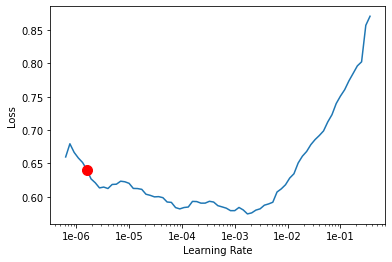

In [0]:
#finding ang plotting the minimum gradient learning rate
learn.lr_find()
learn.recorder.plot(suggestion=True)
min_grad_lr = learn.recorder.min_grad_lr

In [0]:
#fine tuning the model
learn.fit_one_cycle(2, min_grad_lr)

epoch,train_loss,valid_loss,accuracy,time
0,0.587462,0.701766,0.696291,00:03
1,0.589969,0.702804,0.695556,00:03


In [0]:
#unfreezing the last 2 layers and fine tuning
learn.freeze_to(-2)
learn.fit_one_cycle(4, slice(5e-3, 2e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.576178,0.721483,0.694087,00:02
1,0.581998,0.717101,0.690782,00:02
2,0.580481,0.716620,0.688946,00:02
3,0.559386,0.708182,0.696291,00:02


In [0]:
#unfreezing the complete model for final fine tuning
learn.unfreeze()
learn.fit_one_cycle(4, slice(2e-3/100, 2e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.558352,0.707746,0.694087,00:03
1,0.546647,0.723263,0.686008,00:03
2,0.522338,0.713640,0.695924,00:03
3,0.517835,0.700672,0.699229,00:03


In [0]:
#testing with some sentences
learn.predict(clean("चीन के सामने भारत के जांबाज़ सूरमाओं की Exclusive रिपोर्ट कोल्ड डेजर्ट के नाम से मशहूर नेलांग वैली से।… https://t.co/7JBdsL6xaE"))

(Category tensor(2), tensor(2), tensor([0.0145, 0.4698, 0.5156]))

In [0]:
learn.predict(clean("उनसे बातचीत करने से मैं विपरीत हालातों में अच्छा प्रदर्शन करने को प्रेरित होता हूं"))

(Category tensor(2), tensor(2), tensor([0.1394, 0.0324, 0.8282]))

In [0]:
learn.predict(clean("आज़तक पर देखिये कितनी स्मार्ट हुई स्मार्ट फेंसिंग Exclusive आज रात 9.30 pm पर @BSF_India"))

(Category tensor(0), tensor(0), tensor([0.7936, 0.0988, 0.1076]))

In [0]:
learn.predict(clean("इस कारण से किसानों को उनका माल खुले में ही उतारना पड़ रहा है"))

(Category tensor(0), tensor(0), tensor([0.9376, 0.0180, 0.0444]))